Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
有效评论数: 1000
变量相关性矩阵:
[[1.         0.54137335 0.751608  ]
 [0.54137335 1.         0.6548908 ]
 [0.751608   0.6548908  1.        ]]


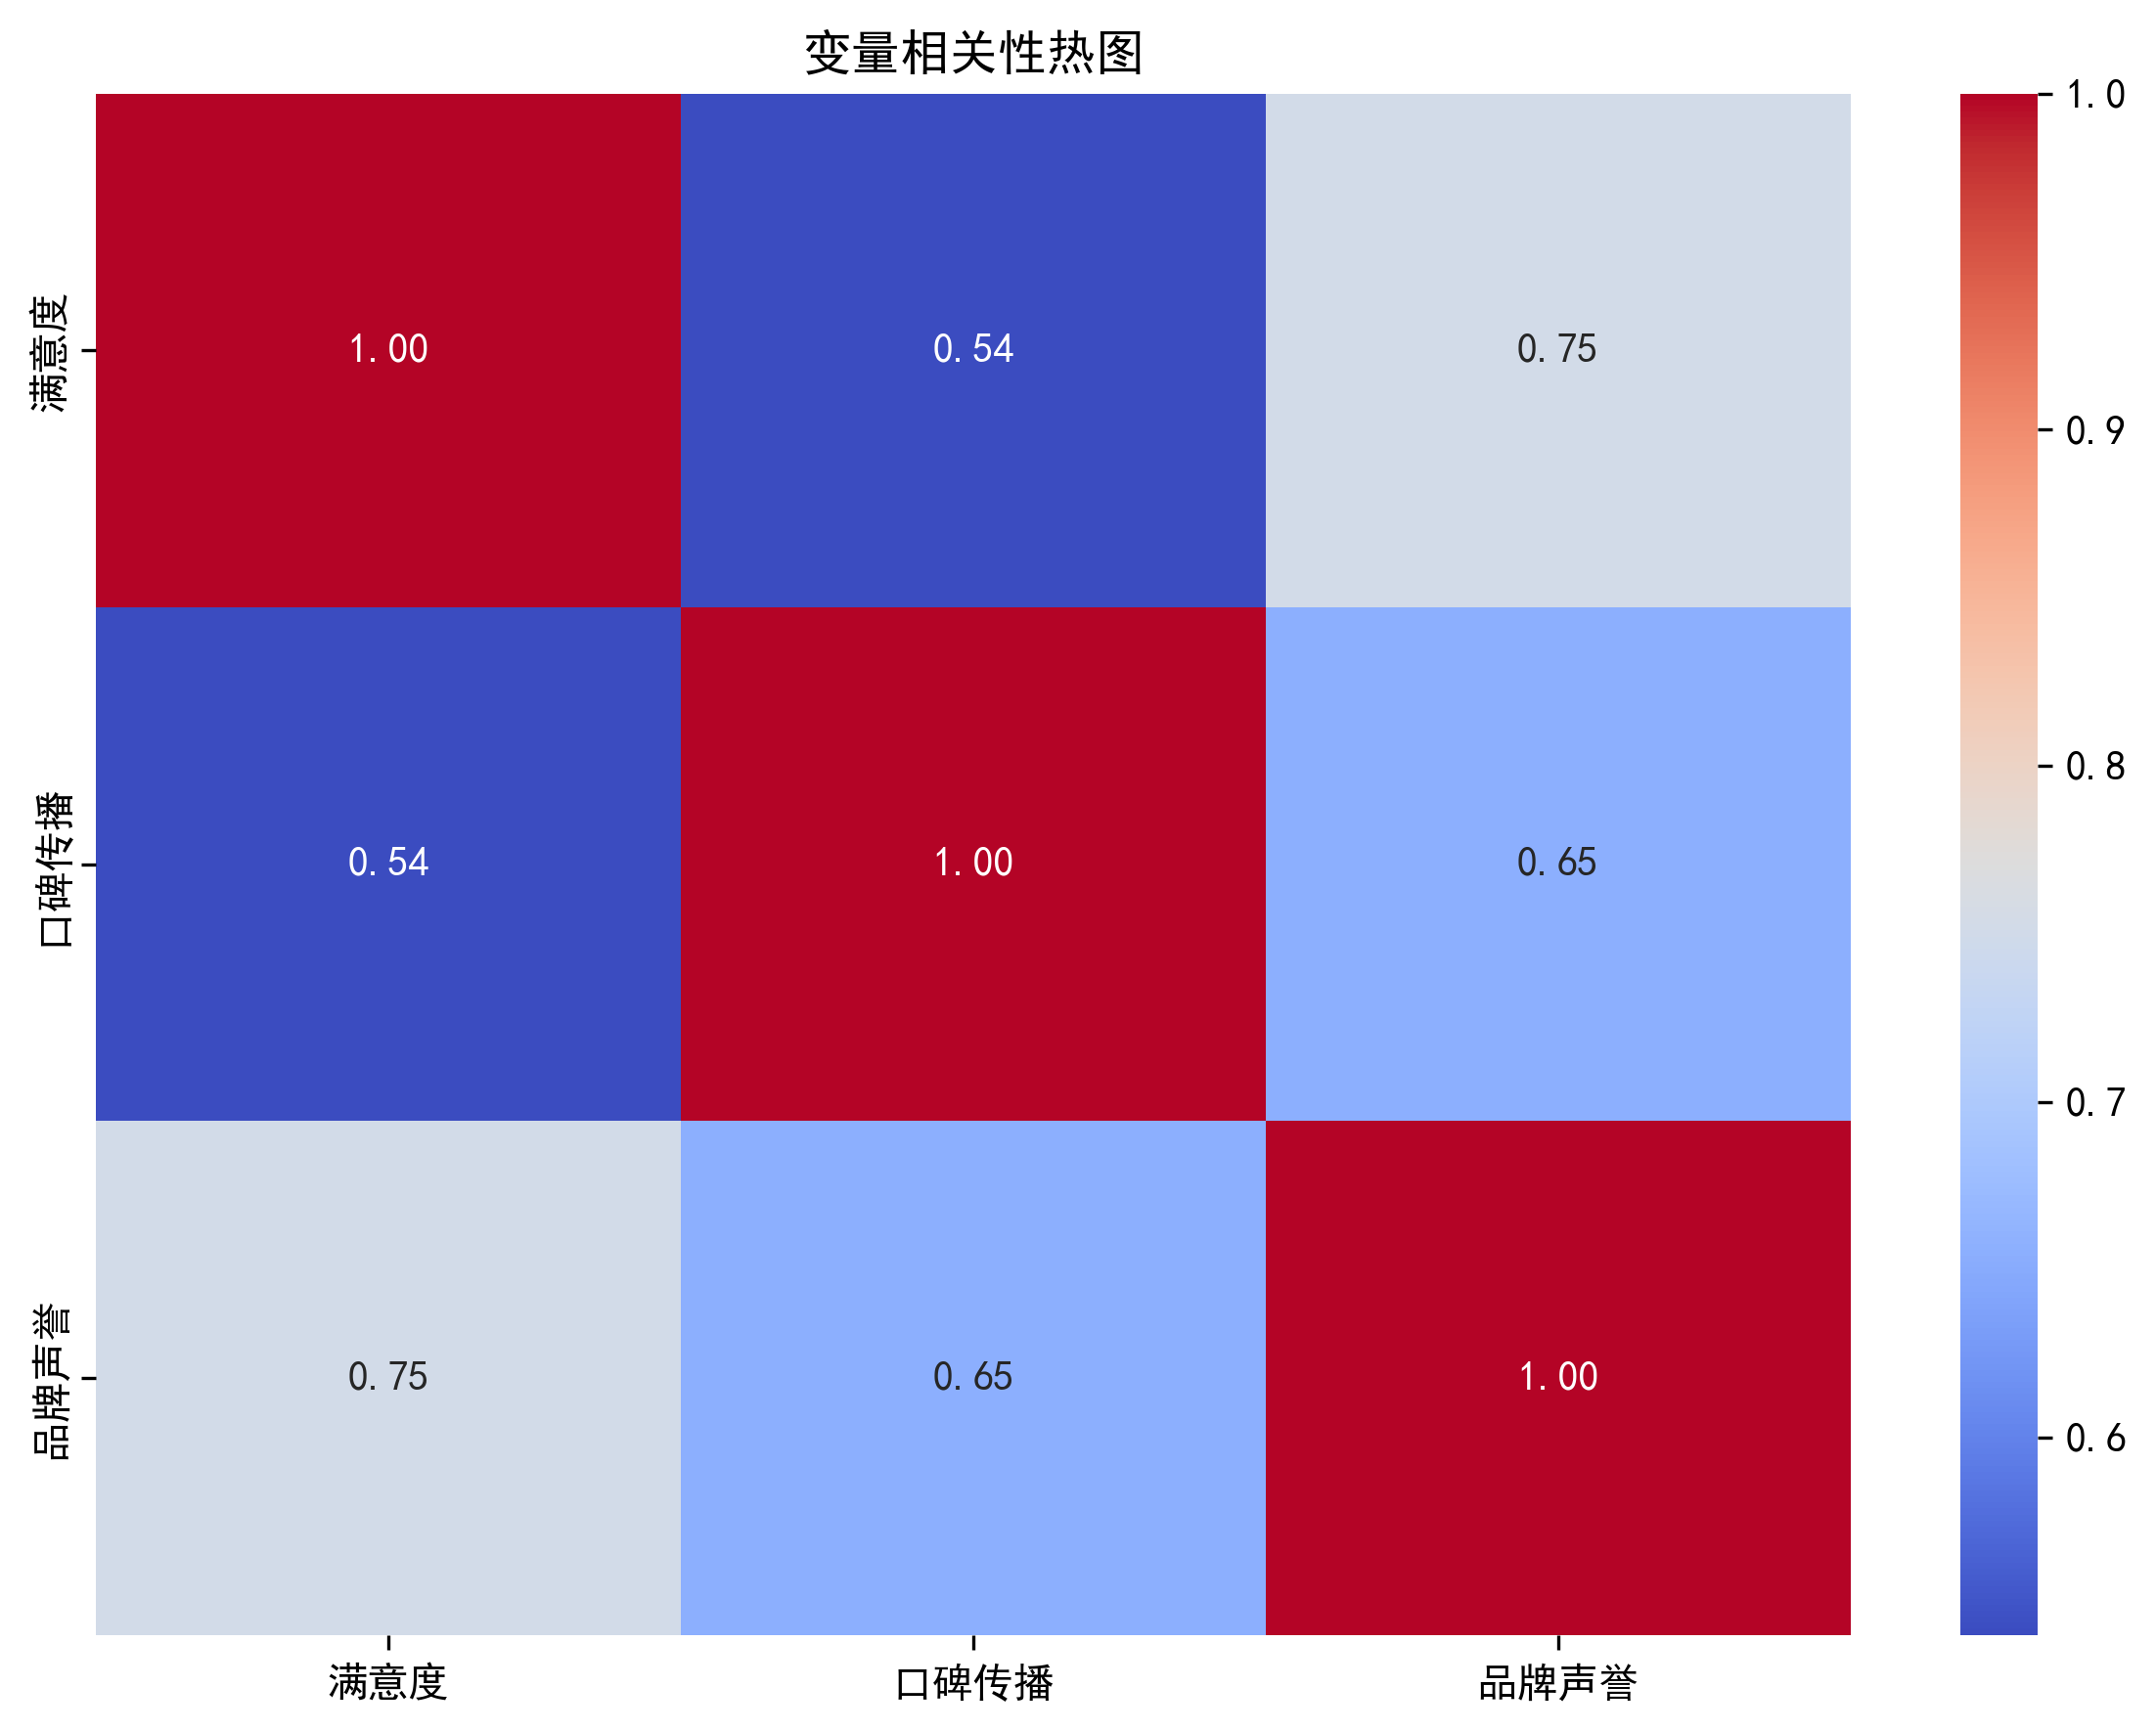

数据处理或模型构建出错: 'dict' object has no attribute 'columns'


In [2]:
# 安装必要的库
!pip install numpy matplotlib seaborn statsmodels scipy semopy openpyxl jieba snownlp -i https://pypi.tuna.tsinghua.edu.cn/simple

# 导入必要的库
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from openpyxl import load_workbook
import os
from snownlp import SnowNLP
import semopy
from semopy import Model

# 设置中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.dpi'] = 300

# 读取Excel数据（替代pandas）
def read_excel_data(file_path):
    try:
        wb = load_workbook(file_path, read_only=True)
        sheet = wb.active
        
        # 获取表头
        header = [cell.value for cell in sheet[1]]
        
        # 获取数据
        data = []
        for row in sheet.iter_rows(min_row=2):
            row_data = [cell.value for cell in row]
            data.append(row_data)
            
        wb.close()
        return header, np.array(data, dtype=object)
    except Exception as e:
        print(f"读取文件出错: {e}")
        return None, None

# 读取数据
file_path = "广州海底捞真实评论数据.xlsx"
header, data = read_excel_data(file_path)

if header is None:
    desktop_path = os.path.join(os.path.expanduser("~"), "Desktop", "广州海底捞真实评论数据.xlsx")
    header, data = read_excel_data(desktop_path)

if header is None:
    print("无法读取数据文件，请检查文件路径")
else:
    try:
        # 获取关键列索引
        comment_idx = header.index('评论内容')
        rating_idx = header.index('评分')
        date_idx = header.index('日期')
        
        # 数据预处理
        # 1. 过滤缺失值（评论内容和评分不能为空）
        valid_mask = np.logical_and(data[:, comment_idx] != '', data[:, rating_idx] != None)
        valid_data = data[valid_mask]
        
        # 2. 提取有效数据
        comments = valid_data[:, comment_idx]
        ratings = valid_data[:, rating_idx].astype(float)
        dates = valid_data[:, date_idx]
        
        print(f"有效评论数: {len(comments)}")
        
        # 3. 计算情感得分（满意度指标）
        def get_sentiment(text):
            try:
                return SnowNLP(str(text)).sentiments
            except:
                return 0.5
        satisfaction = np.array([get_sentiment(text) for text in comments])
        
        # 4. 计算评论长度（口碑传播指标）
        word_of_mouth = np.array([len(str(text)) for text in comments])
        
        # 5. 品牌声誉指标（使用评分）
        brand_reputation = ratings
        
        # 6. 数据标准化
        def standardize(data):
            mean = np.mean(data)
            std = np.std(data)
            return (data - mean) / std if std != 0 else np.zeros_like(data)
        
        satisfaction_std = standardize(satisfaction)
        word_of_mouth_std = standardize(word_of_mouth)
        brand_reputation_std = standardize(brand_reputation)
        
        # 构建数据字典
        data_dict = {
            'satisfaction': satisfaction_std,
            'word_of_mouth': word_of_mouth_std,
            'brand_reputation': brand_reputation_std
        }
        
        # 相关性分析
        def calculate_correlation(data):
            n = len(data)
            corr_matrix = np.corrcoef(data, rowvar=False)
            return corr_matrix
        
        corr_matrix = calculate_correlation(np.column_stack([
            satisfaction_std, word_of_mouth_std, brand_reputation_std
        ]))
        
        print("变量相关性矩阵:")
        print(corr_matrix)
        
        # 可视化相关性矩阵
        plt.figure(figsize=(8, 6))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f',
                   xticklabels=['满意度', '口碑传播', '品牌声誉'],
                   yticklabels=['满意度', '口碑传播', '品牌声誉'])
        plt.title('变量相关性热图')
        plt.tight_layout()
        plt.show()
        
        # 结构方程模型(SEM)构建
        # 定义模型语法
        model_spec = """
        # 测量模型（假设观测变量直接反映潜变量）
        satisfaction =~ satisfaction
        word_of_mouth =~ word_of_mouth
        brand_reputation =~ brand_reputation
        
        # 结构模型
        word_of_mouth ~ satisfaction
        brand_reputation ~ word_of_mouth + satisfaction
        """
        
        # 创建并拟合模型
        model = Model(model_spec)
        result = model.fit(data_dict)
        
        # 模型评估
        print("\n===== 模型拟合指标 =====")
        print(model.fit_status)
        print("卡方统计量: {:.4f}".format(model.chi2))
        print("自由度: {}".format(model.df))
        print("p值: {:.4f}".format(model.pvalue))
        print("CFI: {:.4f}".format(model.cfi))
        print("TLI: {:.4f}".format(model.tli))
        print("RMSEA: {:.4f}".format(model.rmsea))
        
        # 路径系数可视化
        plt.figure(figsize=(12, 8))
        semopy.semplot(model, "sem_path_diagram.png", 
                      plot_covs=True, 
                      edge_color='black',
                      edge_width=1.5,
                      node_color='#00A1FF',
                      node_size=3000,
                      node_labels=True,
                      exog_label=False,
                      info=False)
        
        # 打印路径系数（使用model.inspect()替代inspect函数）
        print("\n===== 路径系数估计 =====")
        path_results = model.inspect()
        for path, info in path_results.items():
            if isinstance(info, dict) and 'Estimate' in info:
                print(f"{path[0]} → {path[1]}: 系数={info['Estimate']:.4f}, p值={info['p-value']:.4f}")
        
        # 中介效应分析
        direct_effect = path_results[('satisfaction', 'brand_reputation')]['Estimate']
        indirect_effect = path_results[('satisfaction', 'word_of_mouth')]['Estimate'] * path_results[('word_of_mouth', 'brand_reputation')]['Estimate']
        total_effect = direct_effect + indirect_effect
        
        print("\n===== 中介效应分析 =====")
        print(f"满意度→品牌声誉 直接效应: {direct_effect:.4f}")
        print(f"满意度→口碑传播→品牌声誉 间接效应: {indirect_effect:.4f}")
        print(f"总效应: {total_effect:.4f}")
        print(f"间接效应占比: {indirect_effect/total_effect*100:.2f}%")
        
        # 保存模型结果
        import csv
        with open('sem_results.csv', 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(['路径', '系数', '标准误差', 't值', 'p值'])
            for path, info in path_results.items():
                if isinstance(info, dict) and 'Estimate' in info:
                    writer.writerow([f"{path[0]}→{path[1]}", 
                                    f"{info['Estimate']:.4f}", 
                                    f"{info['Std.Err.']:.4f}", 
                                    f"{info['t-value']:.4f}", 
                                    f"{info['p-value']:.4f}"])
        print("模型结果已保存至 'sem_results.csv'")
        
    except Exception as e:
        print(f"数据处理或模型构建出错: {e}")